<a href="https://colab.research.google.com/github/phongidoit/Computer_vision/blob/main/Captcha_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
!mkdir /content/Captcha 
!unzip -q '/content/drive/MyDrive/data ML/Captcha.zip' -d /content/Captcha

path = r'/content/Captcha'

In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from skimage.transform import resize 
import keras
import tensorflow as tf
import gc

from sklearn.metrics import confusion_matrix 


This notebook is made by this tutorial: https://keras.io/examples/vision/captcha_ocr/ 

In [4]:
#go through the data, train and split them into

def resize_img(img, target_size=[150, 40, 3]):
  color = (255, 255, 255)
  pass

X, y = [], []
for file in os.listdir(path):
  #print(file)
  
  name = file.split('/')[-1]
  name= name.split('.')[0]
  #break
  #img = cv2.imread(image_name)
  X.append(path+'/'+file)
  y.append(name)
  
print("Number of samples:", len(y))

X_y = list(zip(X, y))
random.shuffle(X_y)
X, y = zip(*X_y)


Number of samples: 113062


In [5]:
count_text=0
for text in y:
  if len(text) != 5:
    count_text += 1
print("Number of sample that have lenght text not equal to 5:",count_text)    

Number of sample that have lenght text not equal to 5: 0


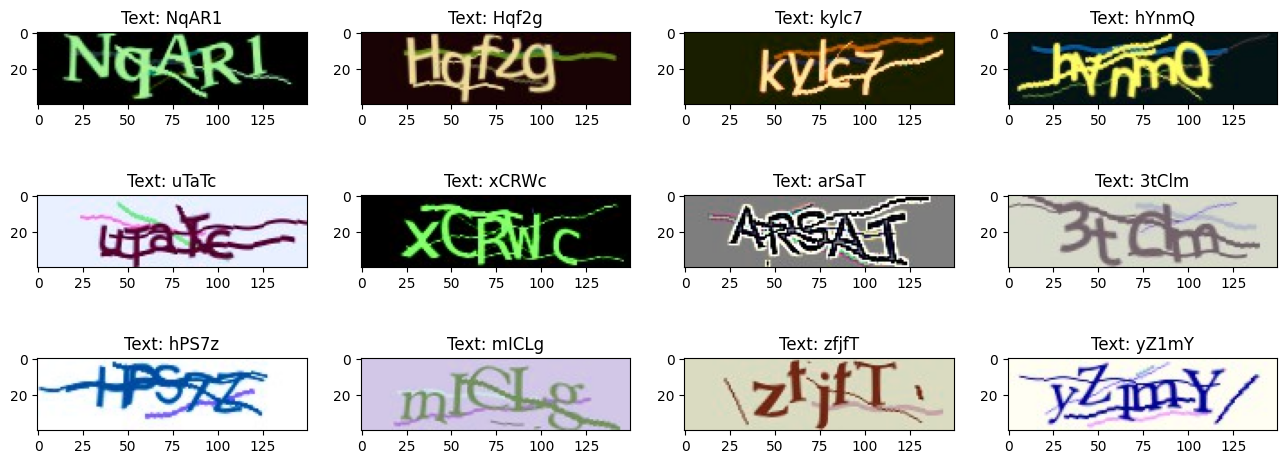

In [6]:
#visualize the set
plt.figure(figsize=(16,6))
for i in range(12):
  plt.subplot(3,4,i+1)
  im = cv2.imread(X[i+1900])
  #out_title = 
  plt.title("Text: "+y[i+1900])
  plt.imshow(im)

In [7]:
from keras import layers
characters = set(char for label in y for char in label)
print(len(characters))
print(characters)

char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


60
{'9', 'Y', 'L', 'E', 'i', 'I', 'D', '4', '2', 'f', 'N', 'G', 's', 'Z', '8', 'R', 'x', 'k', 'V', 'z', 'w', 'h', 'b', 'A', 'J', 'F', 'd', 'H', 'g', 'O', 'p', 'X', 'K', 'y', '6', 'P', 'S', 'j', 'e', 'T', 'v', 'W', 'c', 'q', 'n', '7', '5', 'a', 'm', 'Q', 'u', '3', 'M', '1', 'C', 'U', 'B', 't', 'l', 'r'}


In [8]:
#create dataset and split into train and validtion dataset
n=len(y)
validation_ration, test_ratio = 0.2, 0.2

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.4, random_state= 44)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state= 44)

def encode_image(img_path, label):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [40, 150])
  img = tf.transpose(img, perm=[1, 0, 2])
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  return {"image": img, "label": label}

<Axes: title={'center': 'Number of sample in each dataset'}>

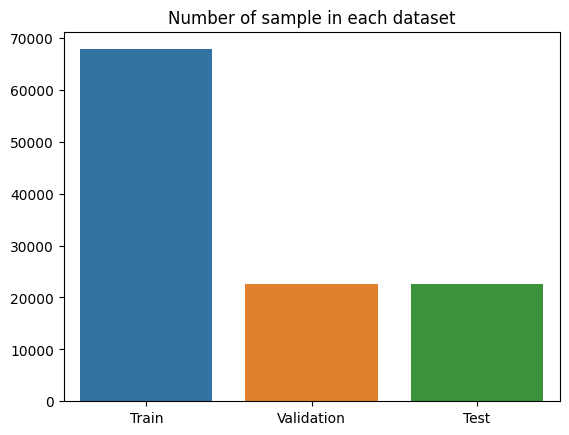

In [9]:
import seaborn as sns
plt.title("Number of sample in each dataset")
sns.barplot(x= ["Train", "Validation", "Test"], y = [len(y_train), len(y_val), len(y_test)])

In [10]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image, num_parallel_calls = tf.data.AUTOTUNE
    )
    .batch(len(X_test))
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

In [11]:
#building the model
from keras import layers

img_width, img_height= 150, 40
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(150, 40, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 40, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 75, 20, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 20, 64)   18496       ['pool1[0][0]']       

In [12]:
epochs = 20
early_stopping_patience = 25

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs= epochs
)

Epoch 1/20
2120/2120 [==============================] - 139s 58ms/step - loss: 21.5063 - val_loss: 20.8342
Epoch 2/20
2120/2120 [==============================] - 120s 56ms/step - loss: 19.7522 - val_loss: 17.5747
Epoch 3/20
2120/2120 [==============================] - 117s 55ms/step - loss: 16.0472 - val_loss: 13.7289
Epoch 4/20
2120/2120 [==============================] - 128s 61ms/step - loss: 13.0746 - val_loss: 11.1040
Epoch 5/20
2120/2120 [==============================] - 138s 65ms/step - loss: 11.0997 - val_loss: 9.3319
Epoch 6/20
2120/2120 [==============================] - 118s 56ms/step - loss: 9.6963 - val_loss: 8.1555
Epoch 7/20
2120/2120 [==============================] - 119s 56ms/step - loss: 8.6756 - val_loss: 7.1907
Epoch 8/20
2120/2120 [==============================] - 117s 55ms/step - loss: 7.8880 - val_loss: 6.5169
Epoch 9/20
2120/2120 [==============================] - 137s 65ms/step - loss: 7.2776 - val_loss: 6.0020
Epoch 10/20
2120/2120 [=======================

In [13]:
#save the model
cp_path = '/content/model.tf'
#model.save(cp_path)

!zip  /content/file.zip  /content/model.tf

  adding: content/model.tf/ (stored 0%)


In [14]:
#save model 2
model.save('/content/model.h5')

In [16]:
#if you have a trained checkpoint, load here so no need to train again
cp_path = '/content/model.h5'
#model_copy = build_model()
model_copy  = keras.models.load_model((cp_path), custom_objects ={"CTCLayer": CTCLayer})

In [34]:
#check validation
def sample_accuracy(pred, true):
  n_samples= len(pred)
  true_predict = 0
  for i in range(len(pred)):
    if pred[i] == true[i]:
      true_predict += 1
  return round(true_predict/n_samples, 4) 

def char_accuracy(pred, true):
  n_char=0
  true_char = 0
  Caps_fail_char = 0
  for i in range(len(pred)):
    n_char += 5
    for k in range(5):
      if pred[i][k] == true[i][k]:
        true_char += 1
      elif pred[i][k].upper() == true[i][k] or pred[i][k].lower() == true[i][k]:
        Caps_fail_char += 1

  return [n_char, true_char, Caps_fail_char]    


In [35]:
import numpy as np
import math

prediction_model = keras.models.Model(
    model_copy.get_layer(name="image").input, model_copy.get_layer(name="dense2").output
)

def decode_output(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  # Use greedy search. For complex tasks, you can use beam search
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
      :, :5
  ]
  # Iterate over the results and get back the text
  output_text = []
  for res in results:
      res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
      output_text.append(res)
  return output_text

val_loss, val_accurates= [], []
n_char, char_correct, mis_cap = 0, 0, 0
#iterate trough every batch
for batch in validation_dataset.take(math.ceil(len(X_val)//batch_size)):
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images, verbose= 0)
  pred_texts = decode_output(preds)
  #print(pred_texts)
  orig_texts = []
  for label in batch_labels:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      orig_texts.append(label)
  #print(orig_texts)      
  val_accurates.append(sample_accuracy(pred_texts, orig_texts))
  temp_return = char_accuracy(pred_texts, orig_texts)
  n_char += temp_return[0]
  char_correct += temp_return[1]
  mis_cap += temp_return[2]
#val_accurates= np.array(val_accurates)


Number of validation batchs:  706
Average accuracy across all batchs:  0.3762
Medium accuracy across all batchs: 0.3750
Accuracy of best batch:  0.75
Number of accurate character predict:  86540 |	 76.6112%
Number of misindentify Upper/Lowercase:  9812 |	 8.6863%|	 37.1385%


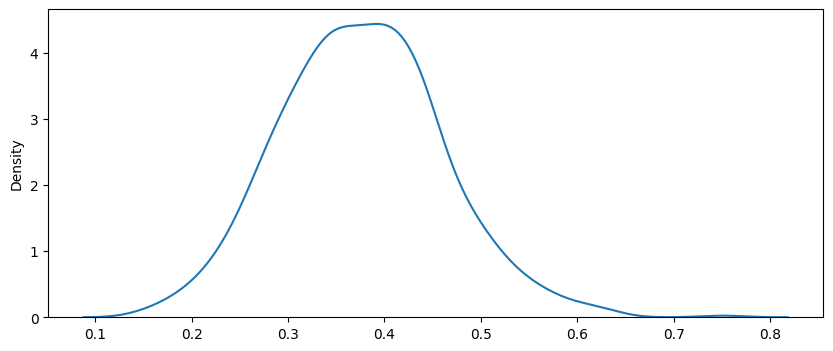

In [38]:
plt.figure(figsize=(10,4))
sns.kdeplot(data = val_accurates)
val_accurates = np.array(val_accurates)
print("Number of validation batchs: ", len(val_accurates))
print("Average accuracy across all batchs: ", f'{val_accurates.mean():.4f}')
print("Medium accuracy across all batchs:", f'{np.median(val_accurates):.4f}')
print("Accuracy of best batch: ", max(val_accurates))
print("Number of accurate character predict: ", char_correct,"|\t", f'{char_correct/n_char*100:.4f}'+'%' )
print("Number of misindentify Upper/Lowercase: ", mis_cap,"|\t", f'{mis_cap/n_char*100:.4f}'+'%|\t',  f'{mis_cap/(n_char-char_correct)*100:.4f}'+'%')

In [28]:
#take failed sample from a batch to visualized

Img, Img_labels, pred_labels=[],[],[]
#iterate trough every batch
for batch in validation_dataset.take(1):
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images, verbose= 0)
  pred_text = decode_output(preds)
  #print(pred_texts)
  true_text = []
  for label in batch_labels:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      true_text.append(label)

for i, text in enumerate(pred_text):
  if text != true_text[i]:
    Img.append(batch_images[i])
    Img_labels.append(true_text[i])
    pred_labels.append(text)
print(len(Img_labels))    
print(Img_labels,'\n', pred_labels) 
Img = [tf.transpose(img, perm=[1, 0, 2]) for img in Img]       

21
['2EUHE', '4jU46', 'AkdJp', 'bnmJ8', 'MQt1P', 'Kfpi8', 'dMGFY', 'KisWe', 'RwVqU', 'l5g63', 'j8h68', 'APVvi', 'Br9Vy', 'zI2Mp', '5OLUT', 'htYEL', 'EMilI', 'RXs21', 'ecIVb', 'eTOus', 'InYOy'] 
 ['2EuHE', 'ijL4a', 'AkqJP', 'bnm18', 'MQfiF', 'KFPi8', 'dMCFY', 'k1SWE', 'RwVdU', 'Pg6s3', 'j8he8', 'AFVvi', 'br9vy', 'z12MP', '5ULU1', 'h1rEL', 'EM1I[UNK]', 'RXs2l', 'eCIVb', 'cTOus', 'lnYOy']


<ipython-input-39-411f1b9277c8>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,6,i+1)


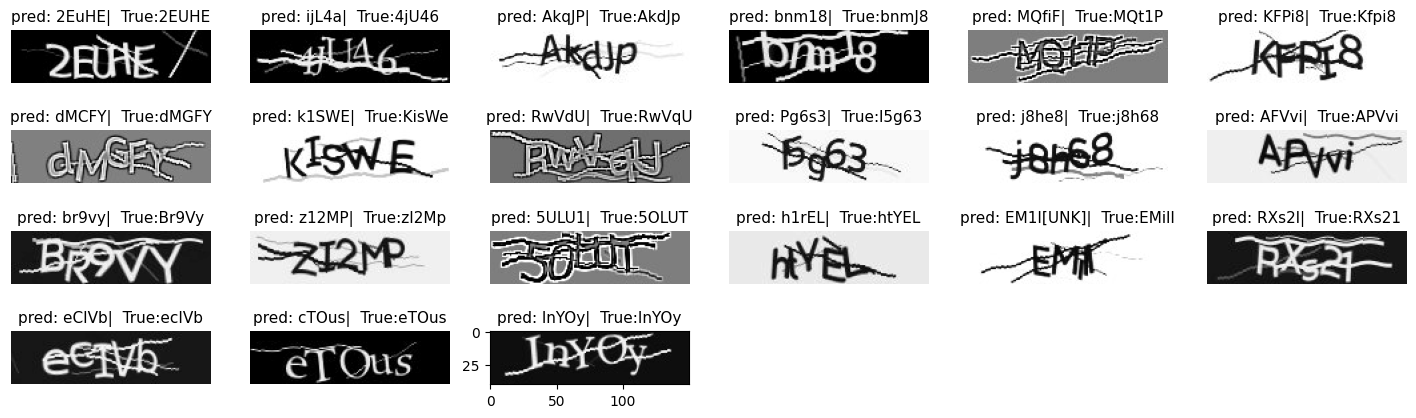

In [39]:
plt.figure(figsize=(18,5))
for i in range(len(Img)):
  plt.axis('off')
  plt.subplot(4,6,i+1)
  out_title= 'pred: ' +pred_labels[i]+"|  True:" + Img_labels[i]
  plt.title(out_title, fontsize=11)
  plt.imshow(Img[i], cmap=plt.cm.gray)

In [54]:
test_loss, test_accurates= [], []
n_char, char_correct, mis_cap = 0, 0, 0
#iterate trough every batch
for batch in test_dataset.take(1):
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images, verbose= 0)
  pred_texts = decode_output(preds)
  #print(pred_texts)
  orig_texts = []
  for label in batch_labels:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      orig_texts.append(label)
  #print(orig_texts)      
  test_accurates.append(sample_accuracy(pred_texts, orig_texts))
  temp_return = char_accuracy(pred_texts, orig_texts)
  n_char += temp_return[0]
  char_correct += temp_return[1]
  mis_cap += temp_return[2]

Number of validation batchs:  1
Average accuracy across all batchs:  0.3763
Medium accuracy across all batchs: 0.3763
Accuracy of best batch:  0.3763
Number of accurate character predict:  86427 |	 76.4401%
Number of misindentify Upper/Lowercase:  9886 |	 8.7436%|	 37.1124%


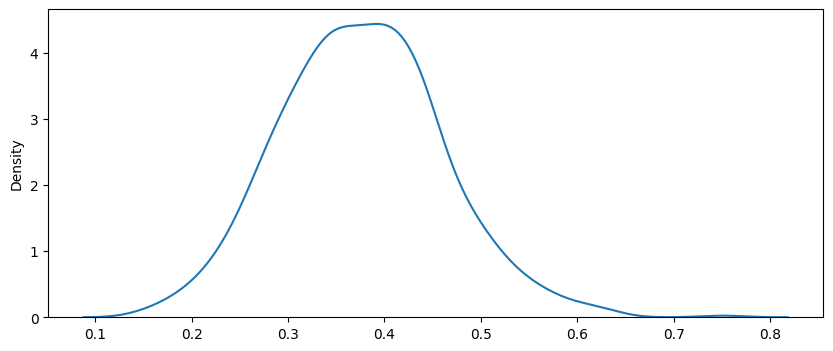

In [42]:
plt.figure(figsize=(10,4))
sns.kdeplot(data = val_accurates)
test_accurates = np.array(test_accurates)

print("Number of validation batchs: ", len(test_accurates))
print("Average accuracy across all batchs: ", f'{test_accurates.mean():.4f}')
print("Medium accuracy across all batchs:", f'{np.median(test_accurates):.4f}')
print("Accuracy of best batch: ", max(test_accurates))
print("Number of accurate character predict: ", char_correct,"|\t", f'{char_correct/n_char*100:.4f}'+'%' )
print("Number of misindentify Upper/Lowercase: ", mis_cap,"|\t", f'{mis_cap/n_char*100:.4f}'+'%|\t',  f'{mis_cap/(n_char-char_correct)*100:.4f}'+'%')

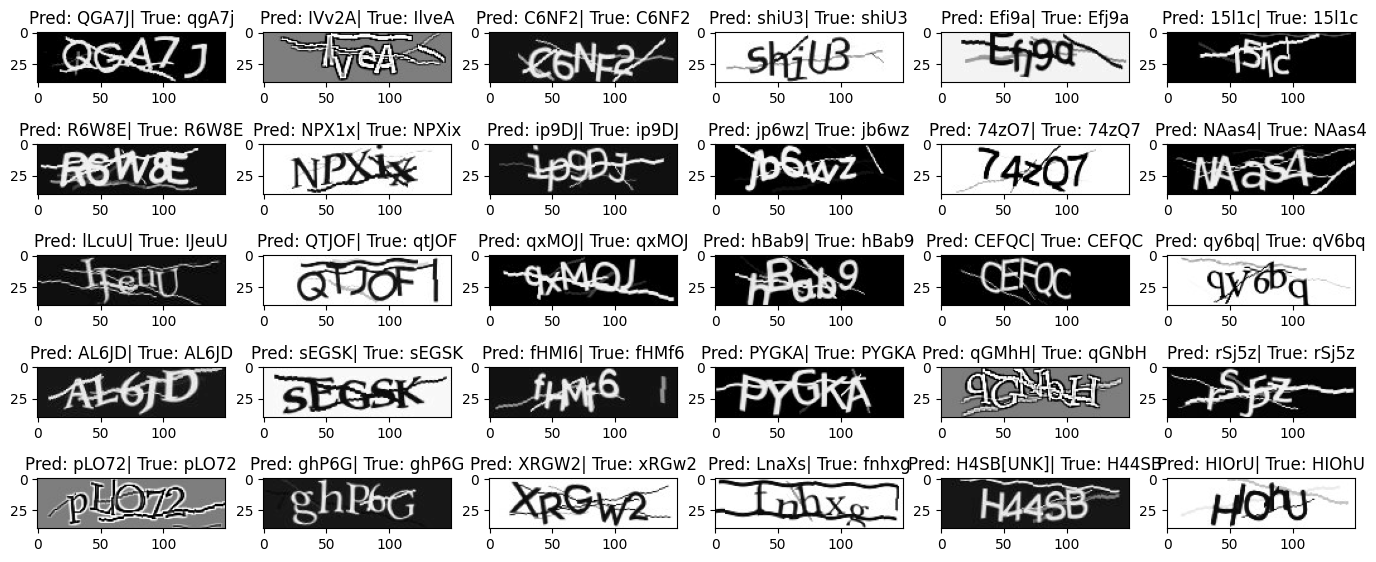

In [59]:
#look through 40 images and prediction in test dataset
"""
if batch_images[0].shape[0] != 40:
    batch_images = [tf.transpose(img, perm=[1, 0, 2]) for img in batch_images]
"""

plt.figure(figsize=(17,7))
for i in range(30):
  plt.subplot(5,6,i+1)
  out = "Pred: "+ pred_texts[i]+"| True: "+orig_texts[i]
  plt.title(out)
  if batch_images[i].shape[0] != 40:
    batch_images[i] = tf.transpose(batch_images[i], perm=[1, 0, 2])
  plt.imshow(batch_images[i], cmap=plt.cm.gray)